In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, IncrementalPCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine, euclidean
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import sparse
import pickle
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [15]:
def get_vectors(data, vect_type='count', **voc_params):
    if vect_type == 'count':
        vectorizer = CountVectorizer(**voc_params)
    elif vect_type == 'tfidf':
            vectorizer = TfidfVectorizer(min_df=2)
    data_vect = vectorizer.fit_transform(data.fillna('')).todense()
    scaler = StandardScaler()
    data_vect = scaler.fit_transform(data_vect)
    return data_vect

def make_pca(data_vect):
    pca = PCA()
    pca.fit(data_vect)
    n_c = (pca.explained_variance_ratio_.cumsum() < 0.95).sum()
    pca = PCA(n_components=n_c)
    data_vect = pca.fit_transform(data_vect)
    return data_vect

def get_devs(df, n_vecs):
    df_list = []
    for i in tqdm(df['group_id'].unique(), total=129):
        df_i = df[df['group_id'] == i]
        vect_i = np.array(df_i.loc[:, [f'{j}_f' for j in range(n_vecs)]])
        mean_i = np.mean(vect_i, axis=0)
        df_i['dev'] = np.apply_along_axis(lambda x: euclidean(x, mean_i), axis=1, arr=vect_i)
        df_list.append(df_i)
    df_with_dev = pd.concat(df_list)
    df = df_with_dev.drop([f'{i}_f' for i in range(n_vecs)], 1)
    return df

def show_hist(df, column='dev'):
    plt.hist(df[df['target'] == 0][column], bins=100, normed=True, label='Out of group')
    plt.hist(df[df['target'] == 1][column], bins=100, normed=True, alpha=0.7, label='In group')
    plt.title('dev distribution')
    plt.legend()

def get_th(proba, y_test):
    scores = []
    ths = np.arange(0.1, 0.9, 0.1)
    for i in ths:
        scores.append(f1_score(y_test, (proba > i)[:, 1]))
    ind = scores.index(max(scores))
    th = np.arange(0.1, 0.9, 0.1)[ind]
    score = f1_score((proba > th)[:, 1], y_test)
    return score, th

# Vectors preparing

In [3]:
titles = pd.read_csv('data/clean_titles.csv')

In [5]:
data_vect_count = get_vectors(titles['clean_title'])
# data_vect_count = make_pca(data_vect_count)

In [4]:
voc_params = {'min_df': 5, 'max_df': 0.8}
vect_titles = get_vectors(titles['clean_title'], **voc_params)

In [16]:
titles_count = titles.join(pd.DataFrame(vect_titles, columns=[f'{i}_f' for i in range(vect_titles.shape[1])]))

In [ ]:
titles_count.to_csv('data/vect_titles_count.csv', index=False)

In [9]:
titles_count = pd.read_csv('data/vect_titles_count.csv')

FileNotFoundError: [Errno 2] File data/vect_titles_count.csv does not exist: 'data/vect_titles_count.csv'

In [6]:
df = pd.read_csv('data/train_groups.csv')

In [17]:
df_count = pd.merge(df, titles_count, how='left', on='doc_id')

In [18]:
df_count = get_devs(df_count, titles_count.shape[1] - 2)

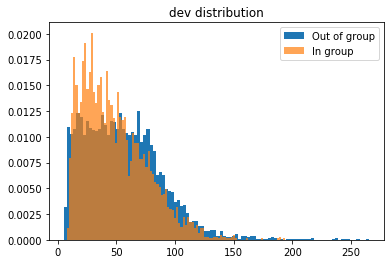

In [19]:
show_hist(df_count)

In [10]:
data_vect_tfidf = get_vectors(titles['clean_title'], vect_type='tfidf')
data_vect_tfidf = make_pca(data_vect_tfidf)

In [11]:
titles_tfidf = titles.join(pd.DataFrame(data_vect_tfidf, columns=[f'{i}_f' for i in range(data_vect_tfidf.shape[1])]))

In [51]:
titles_tfidf.to_csv('data/vect_titles_tf_idf.csv', index=False)

In [47]:
titles_tfidf = pd.read_csv('data/vect_titles_tf_idf.csv')

In [54]:
df_tfidf = pd.merge(df, titles_tfidf, how='left', on='doc_id')
df_tfidf = get_devs(df_tfidf, titles_tfidf.shape[1] - 2)

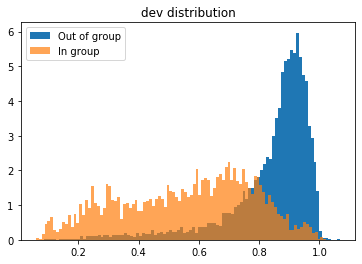

In [55]:
show_hist(df_tfidf)

# Добавим кросс-валидации

In [9]:
class ThresholdModel(BaseEstimator, ClassifierMixin):
    
    def fit(self, X, y):
        scores = []
        ths = np.arange(0, X.max(), 0.01)
        for th in ths:
            scores.append(f1_score(y, (X < th)))
        self.train_score = max(scores)
        ind = scores.index(self.train_score)
        self.th_ = ths[ind]
        return self
    
    def predict(self, X):
        return X < self.th_

In [10]:
def cross_val_score(model, df, train_subset=['dev'], cv=5):
    result = []
    indices = df['group_id'].unique()
    for i in range(cv):
        train_ids = np.random.choice(indices, indices.shape[0] // 2, replace=False)
        test_ids = indices[~np.isin(indices, train_ids)]
        train_data = df[df['group_id'].isin(train_ids)]
        test_data = df[df['group_id'].isin(test_ids)]
        model.fit(np.array(train_data.loc[:, train_subset].fillna(0)).reshape(-1, 1), train_data['target'])
        score = f1_score(model.predict(np.array(test_data.loc[:, train_subset].fillna(0)).reshape(-1, 1)), test_data['target'])
        result.append(score)
    return sum(result) / len(result), model.th_

def linear_model_cross_val_score(model, df, train_subset=['dev'], cv=5):
    indices = df['group_id'].unique()
    result = []
    ths = 0
    for i in range(cv):
        train_ids = np.random.choice(indices, indices.shape[0] // 2, replace=False)
        test_ids = indices[~np.isin(indices, train_ids)]
        train_data = df[df['group_id'].isin(train_ids)]
        test_data = df[df['group_id'].isin(test_ids)]
        model.fit(train_data.loc[:, train_subset].fillna(0), train_data['target'])
        proba = model.predict_proba(test_data.loc[:, train_subset].fillna(0))
        score, th = get_th(proba, test_data['target'])
        ths += th
        result.append(score)
    return sum(result) / len(result), ths / len(result)

In [ ]:
#count 
model = ThresholdModel()
print('My simple model:', cross_val_score(model, df_count))

model = LogisticRegression()
print('Logistic regression:', linear_model_cross_val_score(model, df_count))

In [56]:
# tfidf
model = ThresholdModel()
print('My simple model:', cross_val_score(model, df_tfidf))

model = LogisticRegression()
print('Logistic regression:', linear_model_cross_val_score(model, df_tfidf))

My simple model: 0.6944020483280446
Logistic regression: 0.6875786907676644


# Подготовим сабмит

In [62]:
df_count_train = df_count[df_count['group_id'] > 65]
df_count_test = df_count[df_count['group_id'] <= 65]
data_train = np.array(df_count_train['dev'].fillna(0)).reshape(-1, 1)
data_test = np.array(df_count_test['dev'].fillna(0)).reshape(-1, 1)
target_train = df_count_train['target']
target_test = df_count_test['target']

model = LogisticRegression()
model.fit(data_train, target_train)

proba = model.predict_proba(data_test)
score, th = get_th(proba, target_test)

In [66]:
data = np.array(df_count['dev'].fillna(0)).reshape(-1, 1)
target = df_count['target']

model = LogisticRegression()
model.fit(data, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
df_test = pd.read_csv('data/test_groups.csv')
df_test = pd.merge(df_test, titles_count, how='left', on='doc_id')
df_test = get_devs(df_test, titles_count.shape[1] - 2)

In [67]:
proba = model.predict_proba(np.array(df_test['dev'].fillna(0)).reshape(-1, 1))

In [69]:
df_test['target'] = (proba[:, 1] > th)
df_test['target'] = df_test['target'].apply(lambda x: int(x))

In [72]:
df_test.loc[:, ['pair_id', 'target']].to_csv('predictions/count_lr.csv', index=False)

# Сабмит simple model

In [73]:
model = ThresholdModel()
model.fit(data, target)

ThresholdModel()

In [75]:
df_test['target'] = model.predict(df_test['dev'])
df_test['target'] = df_test['target'].apply(lambda x: int(x))

In [77]:
df_test.loc[:, ['pair_id', 'target']].to_csv('predictions/count_mm.csv', index=False)

# Добавим заголовки из HTML

In [8]:
voc_params = {'min_df': 5, 'max_df': 0.8}
headers = pd.read_csv('data/all_headers.tsv', sep='\t')
vect = get_vectors(headers['headers'], **voc_params)

In [10]:
headers = headers.drop(['headers'], 1)

In [11]:
vect = pd.DataFrame(vect, columns=[f'{i}_f' for i in range(vect.shape[1])])

In [12]:
vect['doc_id'] = headers['doc_id']

In [14]:
df_headers = pd.merge(df, vect, how='left', on='doc_id')

In [15]:
df_headers = get_devs(df_headers, vect.shape[1] - 1)

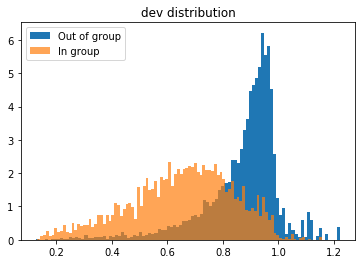

In [16]:
show_hist(df_headers)

In [101]:
#count 
model = ThresholdModel()
print('My simple model:', cross_val_score(model, df_headers))

model = LogisticRegression()
print('Logistic regression:', linear_model_cross_val_score(model, df_headers))

My simple model: (0.6779922313482092, 0.8)
Logistic regression: (0.6539734520246077, 0.28)


In [17]:
df_headers['dev_title'] = df_count['dev']

In [51]:
model = LogisticRegression()
print('Logistic regression:', linear_model_cross_val_score(model, df_headers, train_subset=['dev', 'dev_title']))

Logistic regression: 0.7251385376464526


In [81]:
df_headers['comb_dev'] = np.sqrt(df_headers['dev'] ** 2 + df_headers['dev_title'] ** 2)

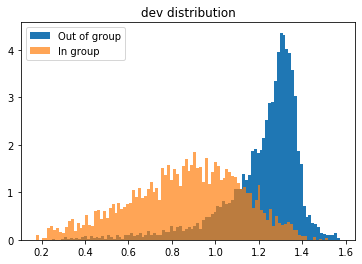

In [103]:
show_hist(df_headers, 'comb_dev')

In [107]:
model = ThresholdModel()
print('My simple model:', cross_val_score(model, df_headers, train_subset=['comb_dev']))

My simple model: (0.7124433356409609, 1.1)


## Сделаем сабмит с логистической регрессией и с бустингом

In [47]:
df_headers_train = df_headers[df_headers['group_id'] > 65]
df_headers_test = df_headers[df_headers['group_id'] <= 65]
data_train = df_headers_train.loc[:, ['dev', 'dev_title']].fillna(0)
data_test = df_headers_test.loc[:, ['dev', 'dev_title']].fillna(0)
target_train = df_headers_train['target']
target_test = df_headers_test['target']

model = LogisticRegression()
model.fit(data_train, target_train)

proba = model.predict_proba(data_test)
score, th = get_th(proba, target_test)

In [44]:
scores = []
ths = []
for _ in range(5):
    score, th = linear_model_cross_val_score(LogisticRegression(), df_headers, ['dev', 'dev_title'], 10)
    scores.append(score)
    ths.append(th)
print(sum(scores) / len(scores), sum(ths) / len(ths))

0.7165506263916811 0.26


In [74]:
score, th = linear_model_cross_val_score(LGBMClassifier(n_estimators=1000, max_depth=1, learning_rate=0.01), df_headers, ['dev', 'dev_title'], 5)
print(score)

0.7200248007148667


In [75]:
print(th)

0.34


In [19]:
data = df_headers.loc[:, ['dev', 'dev_title']].fillna(0)
target = df_headers['target']

model = LogisticRegression()
model.fit(data, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
pickle.dump(model, open('lgbm_2f.pkl', 'wb'))

In [76]:
data = df_headers.loc[:, ['dev', 'dev_title']].fillna(0)
target = df_headers['target']

model = LGBMClassifier(n_estimators=1000, max_depth=1, learning_rate=0.01)
model.fit(data, target)
pickle.dump(model, open('lgbm_2f.pkl', 'wb'))

In [23]:
df_test = pd.read_csv('data/test_groups.csv')
df_test = pd.merge(df_test, titles_count, how='left', on='doc_id')
df_test = get_devs(df_test, titles_count.shape[1] - 2)

In [25]:
df_test['dev_title'] = df_test['dev']

In [29]:
df_test = pd.merge(df_test, vect, how='left', on='doc_id')

In [32]:
df_test = get_devs(df_test, size)

In [77]:
proba = model.predict_proba(df_test.loc[:, ['dev', 'dev_title']].fillna(0))

In [78]:
df_test['target'] = (proba[:, 1] > th)
df_test['target'] = df_test['target'].apply(lambda x: int(x))

In [80]:
df_test.loc[:, ['pair_id', 'target']].to_csv('predictions/count_lr_2f.csv', index=False)

In [ ]:
df_test.loc[:, ['pair_id', 'target']].to_csv('predictions/count_lgbm_2f.csv', index=False)

# Сабмит с комбинированным признаком

In [115]:
scaler = StandardScaler(with_mean=False)
df_headers['comb_norm_dev'] = scaler.fit_transform(np.array(df_headers['comb_dev']).reshape(-1, 1))

In [122]:
model = ThresholdModel()
print('My simple model:', cross_val_score(model, df_headers, train_subset=['comb_norm_dev']))

My simple model: (0.7119082821556066, 4.11)


In [123]:
model = ThresholdModel()
model.fit(df_headers['comb_norm_dev'], df['target'])
print(model.th_)

4.17


In [124]:
df_test['comb_dev'] = np.sqrt(df_test['dev'] ** 2 + df_test['dev_title'] ** 2)

In [125]:
df_test['comb_norm_dev'] = scaler.transform(np.array(df_test['comb_dev']).reshape(-1, 1))

In [126]:
df_test['target'] = model.predict(df_test['comb_norm_dev'])
df_test['target'] = df_test['target'].apply(lambda x: int(x))

In [127]:
df_test.loc[:, ['pair_id', 'target']].to_csv('predictions/count_mm_2f_norm.csv', index=False)